In [2]:
import numpy as np      
import pandas as pd
from operator import mul
from matplotlib import pyplot as plt

# Parallel processing comparation between OpenMP, CUDA and MPI
We start by loading the benchmark results into a data frame and aggregating multiple runs by geometric mean

In [14]:
# Declare index structure
col = ("test250", "test500", "test750", "test1", "test1.5", "test2", "test2.5", "test3", "test3.5", "test4", "test4.5")
scol = [str(i) for i in range(1,8)]
mcol = pd.MultiIndex.from_product([col,scol])

row =  ("seq", "omp", "cuda", "mpi", "mpi_br", "cuda_dim")
srow = ("cycles", "real_time_nsec", "PAPI_TOT_INS", "PAPI_TOT_CYC")
mrow = pd.MultiIndex.from_product([row,srow])

row = ("mpi", "mpi_br")
sr_row = ("Send", "Recv")
sr_mrow = pd.MultiIndex.from_product([row, sr_row, srow])

# Recollect data
df = pd.DataFrame(np.loadtxt("results/total_time.csv", delimiter=','), index=mrow, columns=mcol)
sr_df = pd.DataFrame(np.loadtxt("results/mpi_sr_time.csv", delimiter=','), index=sr_mrow, columns=mcol)
pr_df = pd.DataFrame(np.loadtxt("results/predator-seq-results.csv", delimiter=','), index=srow, columns=mcol)

# Compute geometric mean for total cpu time and send/recive time
gmean = pd.DataFrame(np.full((mrow.size, len(col)), np.nan), index=mrow, columns=col)
sr_gmean = pd.DataFrame(np.full((sr_mrow.size, len(col)), np.nan), index=sr_mrow, columns=col)
pr_gmean = pd.DataFrame(np.full((len(srow), len(col)), np.nan), index=srow, columns=col)
for c in col:
    gmean[c] = df[c].aggregate(lambda ite: ite.prod()**(1.0/len(ite)), axis="columns")
    sr_gmean[c] = sr_df[c].aggregate(lambda ite: ite.prod()**(1.0/len(ite)), axis="columns")
    pr_gmean[c] = pr_df[c].aggregate(lambda ite: ite.prod()**(1.0/len(ite)), axis="columns")


# Display geometric mean dataframe
df.loc["cuda_dim", "real_time_nsec"].at["test4.5"].std() / df.loc["cuda", "real_time_nsec"].at["test4.5"].std()

1.061380217261803

The data is structured by the computation technique and tecnology used.

## Comparing speed-ups between the different techniques

# USEFUL

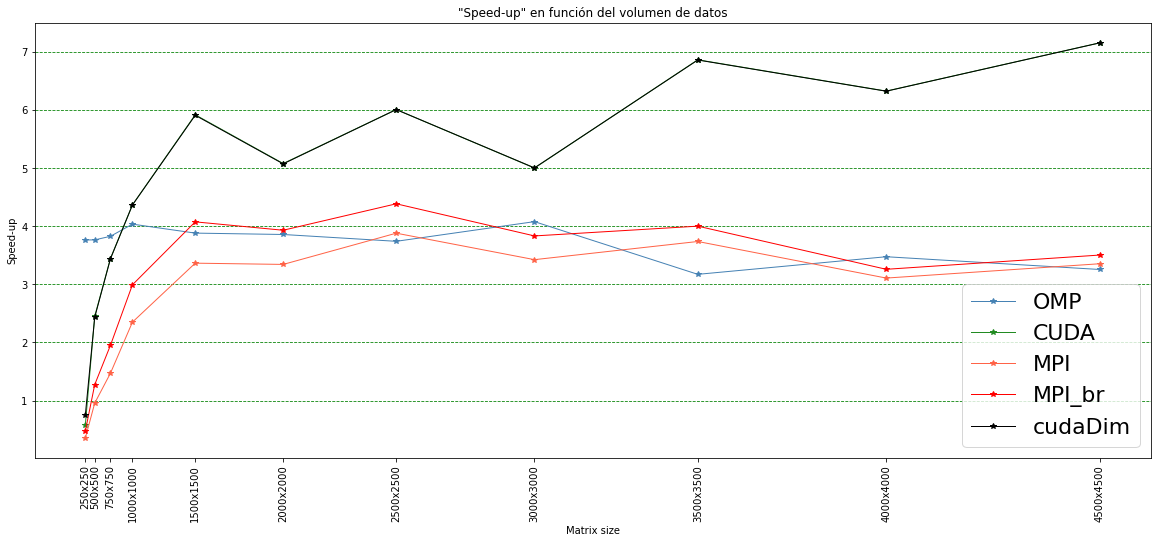

In [35]:
omp_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["omp", "real_time_nsec"])
cuda_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["cuda", "real_time_nsec"])
mpi_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["mpi", "real_time_nsec"])
mpi_br_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["mpi_br", "real_time_nsec"])
cuda_dim_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["cuda_dim", "real_time_nsec"])


real_xaxis = np.array([250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500])**2

fig, ax = plt.subplots()

xlabel = ['250x250', '500x500', '750x750', '1000x1000', '1500x1500', '2000x2000', '2500x2500','3000x3000', '3500x3500','4000x4000', '4500x4500']
edgewidth = 1

ax.plot(real_xaxis, omp_sp,'*-', label='OMP', color="steelblue", linewidth=edgewidth)
ax.plot(real_xaxis, cuda_sp, '*-', color="forestgreen", label='CUDA', linewidth=edgewidth)
ax.plot(real_xaxis, mpi_sp, '*-', color="tomato", label='MPI', linewidth=edgewidth)
ax.plot(real_xaxis, mpi_br_sp, '*-', color="red", label='MPI_br', linewidth=edgewidth)
ax.plot(real_xaxis, cuda_dim_sp, '*-', color="black", label='cudaDim', linewidth=edgewidth)

ax.set_title("\"Speed-up\" en función del volumen de datos")
ax.set_ylabel("Speed-up")
ax.set_xlabel("Matrix size")
ax.set_xticks(real_xaxis)
ax.set_xticklabels(xlabel, rotation=90)
ax.grid(zorder=0, color='green', linestyle='--', axis='y')
ax.legend(fontsize=22)

fig.set_size_inches((20, 8))

# MAYBE USEFUL

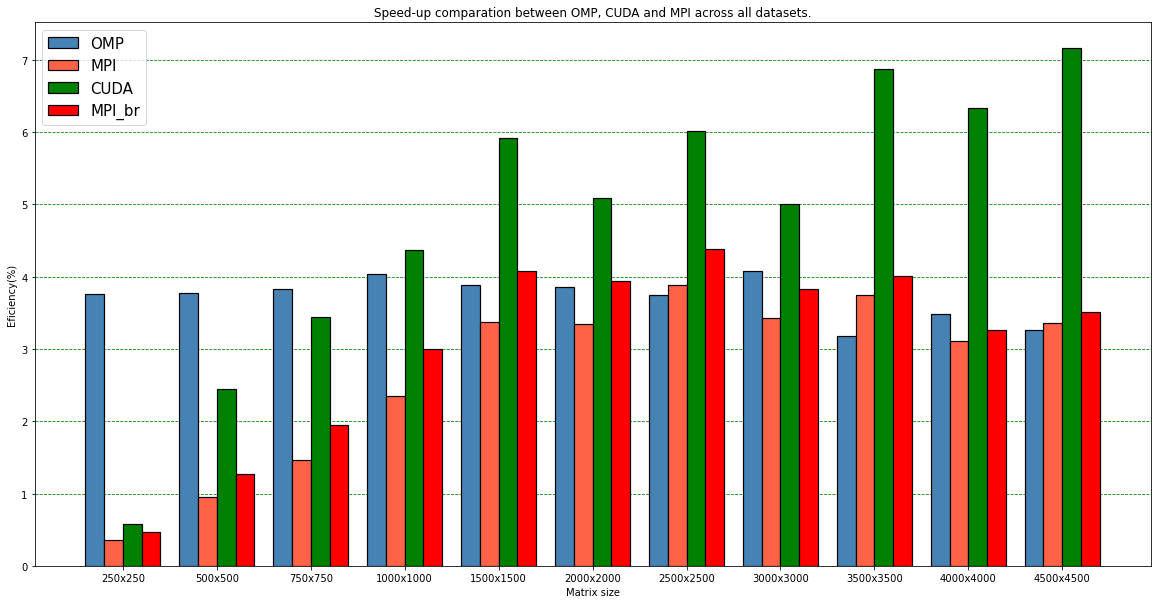

In [34]:
fig, ax = plt.subplots()

xaxis = np.arange(1, len(xlabel)*1.25+1, 1.25)
width = 0.25
edgewidth = 1.2

ax.bar(xaxis - 1.5*width, omp_sp, width,label='OMP', color="steelblue", edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis - width/2, mpi_sp, width, color="tomato", label='MPI', edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis + width/2, cuda_sp, width, color="green", label='CUDA', edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis + 1.5*width, mpi_br_sp, width, color="red", label='MPI_br', edgecolor='black', linewidth=edgewidth)

ax.set_title("Speed-up comparation between OMP, CUDA and MPI across all datasets.")
ax.set_ylabel("Eficiency(%)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=15)
ax.set_axisbelow(True)
ax.grid(zorder=0, color='green', linestyle='--', axis='y')

fig.set_size_inches((20,10))

plt.show()

# TO BE INCLUDED (TALKING ABOUT PARALLELISM EFICIENCY)

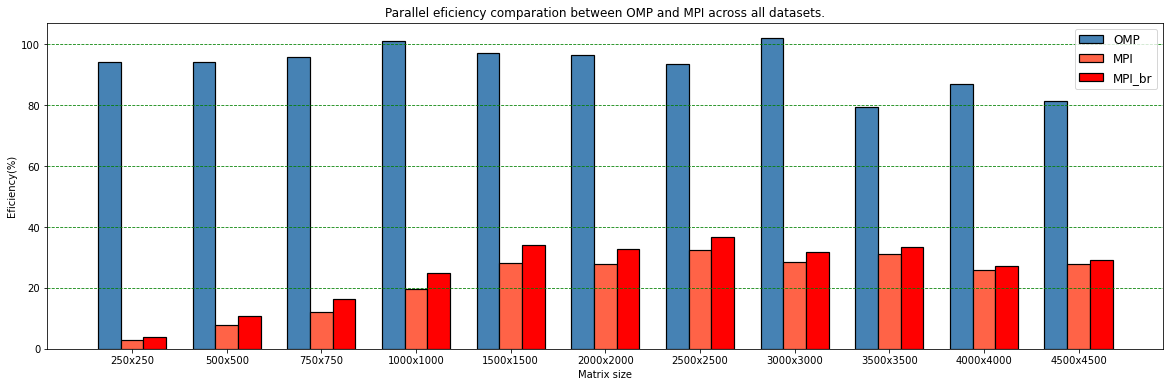

In [31]:
omp_cores = 4
mpi_cores = 12

omp_ef =    100*omp_sp/omp_cores
mpi_ef =    100*mpi_sp/mpi_cores
mpi_br_ef = 100*mpi_br_sp/mpi_cores

fig, ax = plt.subplots()

width = 0.3

ax.bar(xaxis - width, omp_ef, width,label='OMP', color="steelblue", edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis , mpi_ef, width, color="tomato", label='MPI', edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis + width, mpi_br_ef, width, color="red", label='MPI_br', edgecolor='black', linewidth=edgewidth)

ax.set_title("Parallel eficiency comparation between OMP and MPI across all datasets.")
ax.set_ylabel("Eficiency(%)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=12)
ax.grid(color='green', axis='y', linestyle='--')

fig.set_size_inches((20,6))

plt.show()


# COMPARACIÓN ENTRE EL TIEMPO DE ENVÍO DE POR FILAS Y POR ELEMENTOS (MATRIZ ENTERA)

VERY USEFUL AND INTERESTING

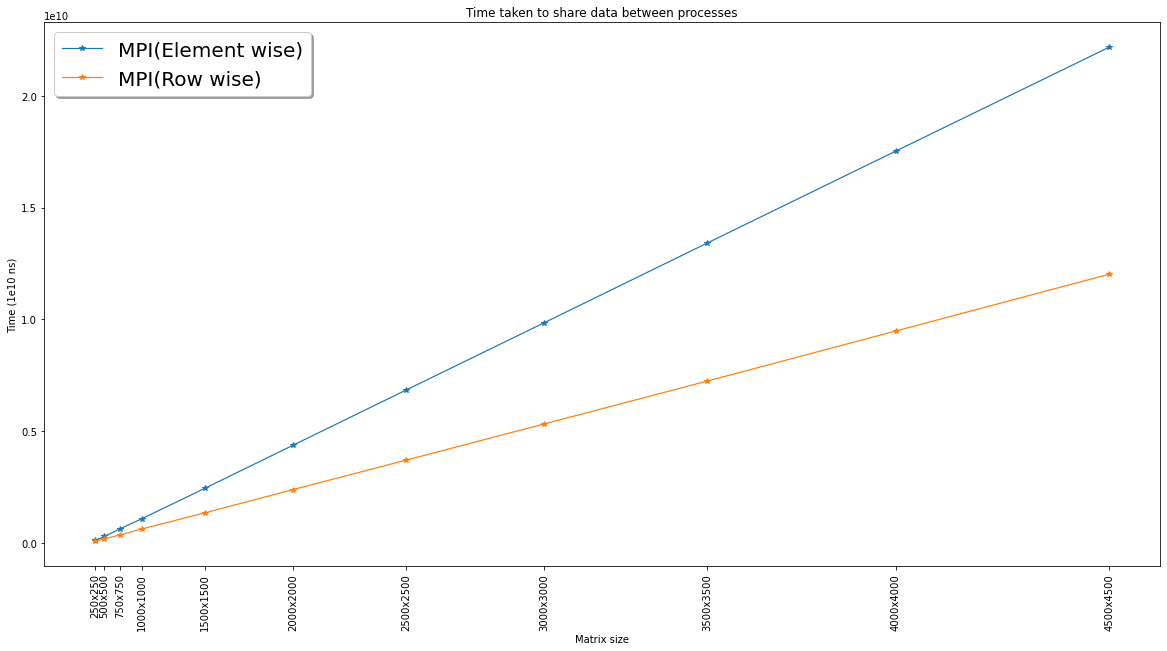

In [20]:
st = sr_gmean.loc["mpi", "Send", "real_time_nsec"]
st_br = sr_gmean.loc["mpi_br", "Send", "real_time_nsec"]

fig, ax = plt.subplots()
ax.plot(real_xaxis, st, '*-', label='MPI(Element wise)', linewidth=edgewidth)
ax.plot(real_xaxis, st_br, '*-', label='MPI(Row wise)', linewidth=edgewidth)

ax.set_title("Time taken to share data between processes")
ax.set_ylabel("Time (1e10 ns)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel, rotation=90)
ax.set_xticks(real_xaxis)
ax.legend(fontsize=20, shadow=True, fancybox=True)


fig.set_size_inches((20,10))

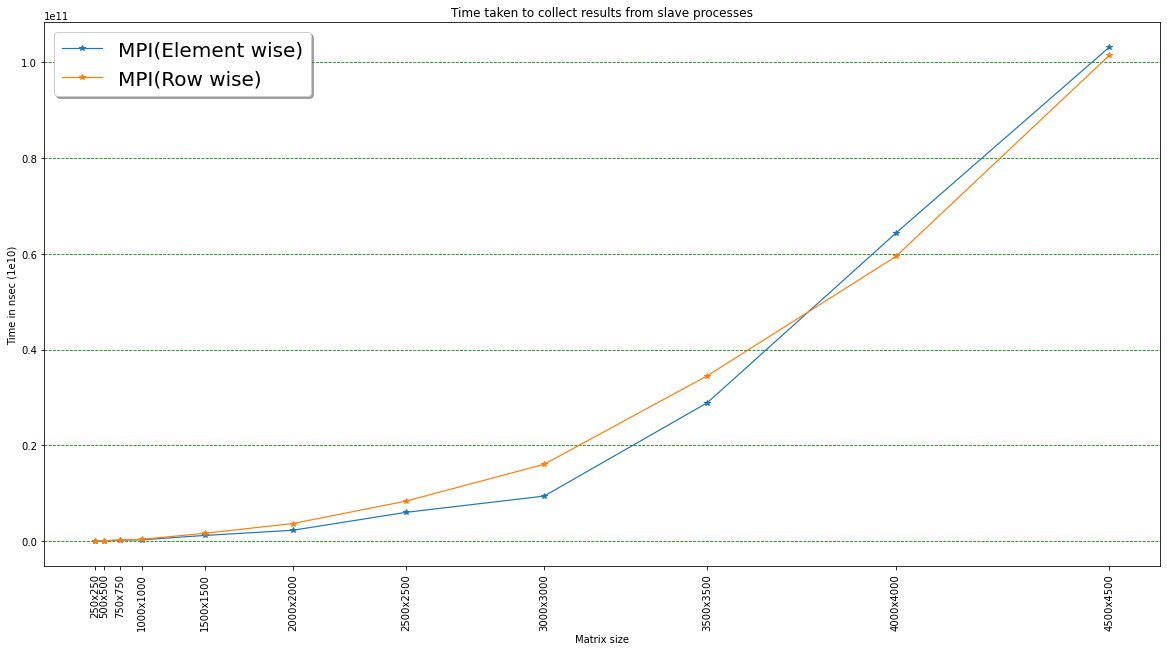

In [30]:
st = sr_gmean.loc["mpi", "Recv", "real_time_nsec"]
st_br = sr_gmean.loc["mpi_br", "Recv", "real_time_nsec"]

fig, ax = plt.subplots()
ax.plot(real_xaxis, st, '*-', label='MPI(Element wise)', linewidth=edgewidth)
ax.plot(real_xaxis, st_br, '*-', label='MPI(Row wise)', linewidth=edgewidth)

ax.set_title("Time taken to collect results from slave processes")
ax.set_ylabel("Time in nsec (1e10)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel, rotation=90)
ax.set_xticks(real_xaxis)
ax.legend(fontsize=20, shadow=True, fancybox=True)
ax.grid(color='green', linestyle = '--', axis='y')

fig.set_size_inches((20,10))

# NOT USEFULL

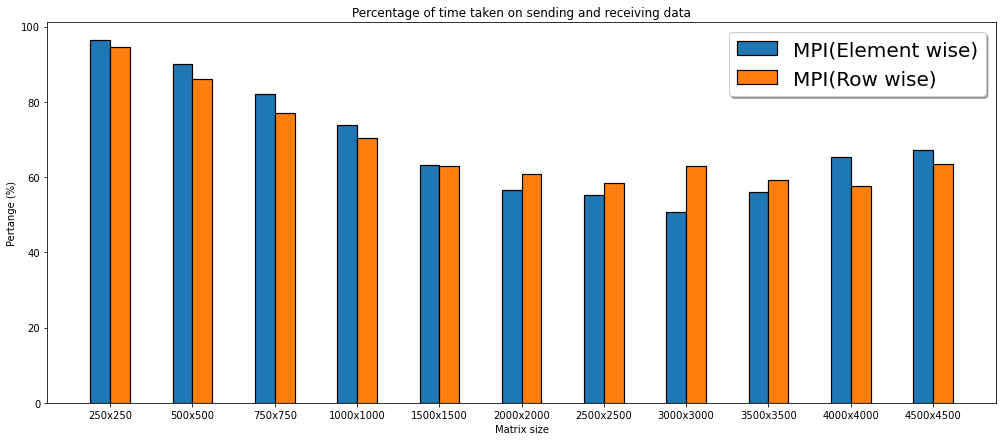

In [23]:
mpi_sr_time_per = 100*sr_gmean.loc["mpi", :, sr_gmean.index.get_level_values(2)=='real_time_nsec'].aggregate(sum) / gmean.loc["mpi", "real_time_nsec"]
mpi_br_sr_time_per = 100*sr_gmean.loc["mpi_br", :, sr_gmean.index.get_level_values(2)=='real_time_nsec'].aggregate(sum) / gmean.loc["mpi_br", "real_time_nsec"]


fig, ax = plt.subplots()
ax.bar(xaxis-width/2, mpi_sr_time_per, width, label='MPI(Element wise)',edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis+width/2, mpi_br_sr_time_per, width, label='MPI(Row wise)',edgecolor='black', linewidth=edgewidth)

ax.set_title("Percentage of time taken on sending and receiving data")
ax.set_ylabel("Pertange (%)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=20, shadow=True, fancybox=True)

fig.set_size_inches((17,7))

# TIME TAKEN TO COMPUTE, SEQUENTIAL: VERY USEFUL

1.1052053019058925

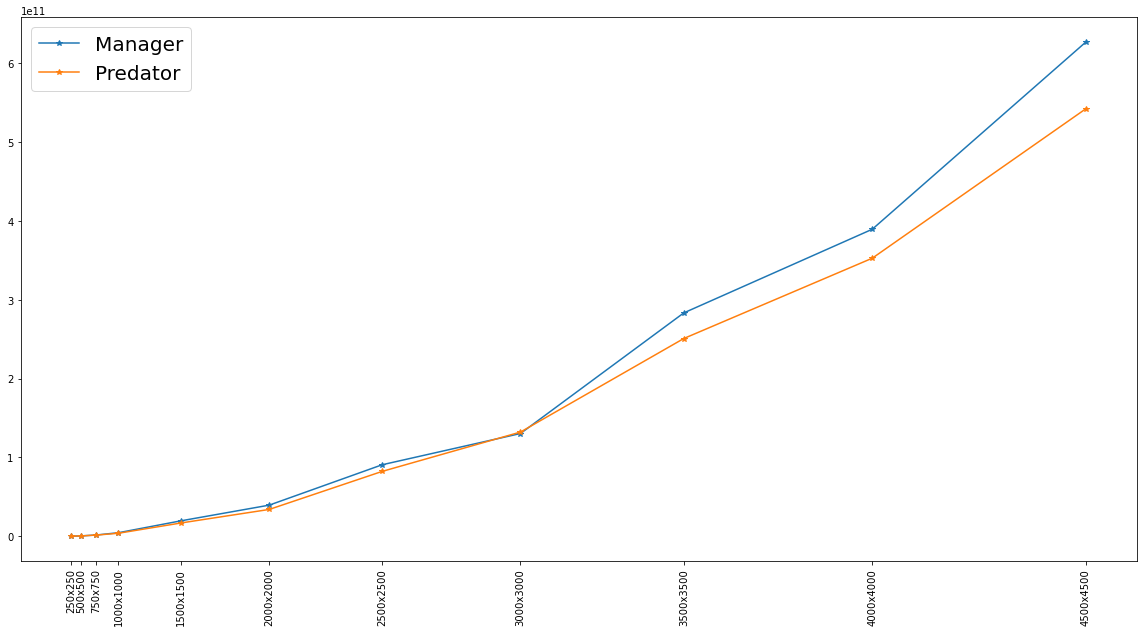

In [24]:
pr_time = pr_gmean.loc["real_time_nsec"]
pc_time = gmean.loc["seq", "real_time_nsec"]

fig, ax = plt.subplots()

ax.plot(real_xaxis, pc_time, '*-', label='Manager')
ax.plot(real_xaxis, pr_time, '*-', label='Predator')

ax.set_xticks(real_xaxis)
ax.set_xticklabels(xlabel, rotation=90)
ax.legend(fontsize=20)

fig.set_size_inches((20,10))

speed_ups = pc_time / pr_time
mean_speed_up = np.cumprod(speed_ups)[-1] ** (1/speed_ups.size)

mean_speed_up